In [1]:
import os
import re
import glob 
import tables
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
TSUN = 4.9169e-6
gbfisher_columns = ['f','colatitude','longitude','amplitude','inclination','polarization','phase','fdot','fddot','sigma_df/f','sigma_colatitude','sigma_longitude','sigma_dA/A','sigma_inclination','sigma_polarization','sigma_phase','sigma_dfdot/fdot','sigma_dfddot/fddot','sigma_Omega','SNR','b','l','mchirp','distance'] 
gbfisher = pd.read_table('../ldasoft/gbfisher_example/gbfisher_parameters.dat',delimiter=' ', header=None,index_col=False,names=gbfisher_columns)
gbfisher['inclination'] = 90 - abs(np.degrees(gbfisher['inclination']) - 90)
gbfisher['sigma_inclination'] = 90 - abs(np.degrees(gbfisher['sigma_inclination']) - 90)
gbfisher['sigma_mchirp'] = (1/(5*TSUN))*((5/3)**(3/5))*(np.pi**(-8/5))*(gbfisher['f']**(-11/5))*(gbfisher['fdot']**(3/5))*((121*(gbfisher['sigma_df/f']**2) + 9*(gbfisher['sigma_dfdot/fdot']**2))**(1/2))
    
gbfisher.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR,b,l,mchirp,distance,sigma_mchirp
0,0.001676,1.742900,3.21926,5.132260e-22,35.434727,0.119065,0.053879,5.349690e-18,6.261139e-32,3.963916e-11,...,0.219315,0.056970,-inf,0.117463,220.517232,50.098915,283.197894,0.306535,227.035211,0.083823
1,0.001686,1.959690,4.18309,4.992740e-22,61.196055,2.960920,3.473620,1.841650e-17,7.375518e-31,6.207588e-11,...,0.035544,0.025594,-inf,0.183266,143.638979,12.539778,331.274456,0.635108,789.019939,0.078025
2,0.001691,0.313511,4.12930,1.779410e-22,49.809665,1.064580,3.407180,3.240390e-18,2.277064e-32,1.506616e-10,...,0.196857,0.364526,-inf,0.485030,56.527459,38.339666,77.225309,0.222560,386.321022,0.389418
3,0.001702,2.178700,3.48736,4.884920e-22,63.076924,0.756933,3.169840,3.349880e-18,2.417760e-32,6.524802e-11,...,0.033836,0.148780,-inf,0.150146,136.753106,22.718375,293.919703,0.223815,142.666142,0.159836
4,0.001887,1.911840,4.39286,1.778240e-22,46.094607,2.949070,2.816580,5.008740e-18,4.874412e-32,1.040668e-10,...,0.182223,0.157411,-inf,0.461285,85.737590,5.210897,340.320530,0.226961,429.752804,0.171485


In [3]:
gwemlisa_columns = ['B_n','O_n','q','+s_q','-s_q','i','+s_i','-s_i']
binDir = os.path.join(os.getcwd(),'out-gwprior')
exclude = ['fdot','inc']
data = []

for binary in os.listdir(binDir):
    for foldername in os.listdir(os.path.join(binDir,binary)):
        if os.path.isdir(os.path.join(binDir,os.path.join(binary,foldername))) & (not foldername in exclude):
            q = []
            i = []
            B_n = int(re.search('binary(.+?)row',foldername).group(1))
            O_n = int(re.search('row(.+?)_incl',foldername).group(1))
            binPath = os.path.join(foldername,'post_equal_weights.dat')
            
            rawbin = open(os.path.join(binDir,os.path.join(binary,binPath)),'r')
            for pos, line in enumerate(rawbin):
                values = [float(i) for i in line.split()]
                q.append(values[2])
                i.append(90 - abs(values[4] - 90))
            rawbin.close()
            q_50, q_10, q_90 = np.percentile(q,50), np.percentile(q,10), np.percentile(q,90)
            i_50, i_10, i_90 = np.percentile(i,50), np.percentile(i,10), np.percentile(i,90)
            
            data.append([B_n, O_n, q_50, q_90-q_50, q_50-q_10, i_50, i_90-i_50, i_50-i_10])
gwemlisa = pd.DataFrame(data,columns=gwemlisa_columns)
gwemlisa = gwemlisa.sort_values(['B_n','O_n']).reset_index(drop=True)
gwemlisa.head()

,B_n,O_n,q,+s_q,-s_q,i,+s_i,-s_i
0,1,0,0.740956,0.201798,0.187535,14.960601,20.157675,12.214742
1,1,1,0.742059,0.198175,0.191850,13.401203,20.448536,10.874313
2,1,2,0.728611,0.211028,0.178085,15.091227,20.448352,11.826373
3,1,3,0.751822,0.180271,0.187085,14.888388,20.065712,12.409819
4,1,4,0.748420,0.203178,0.195434,16.112049,19.171949,13.545854


In [4]:
mc_gwemlisa_columns = ['B_n','mc','+s_mc','-s_mc']
binDir = os.path.join(os.getcwd(),'out-gwprior')
data = []
for binary in os.listdir(binDir):
    mc = []
    B_n = int(re.search('binary(.*)',binary).group(1))
    mcPath = os.path.join('fdot','2-post_equal_weights.dat')
    
    rawmc = open(os.path.join(binDir,os.path.join(binary,mcPath)),'r')
    for pos, line in enumerate(rawmc):
        values = [float(i) for i in line.split()]
        mc.append(values[0])
    rawmc.close()
    mc_50, mc_10, mc_90 = np.percentile(mc,50), np.percentile(mc,10), np.percentile(mc,90)
            
    data.append([B_n, mc_50, mc_90-mc_50, mc_50-mc_10])
mc_gwemlisa = pd.DataFrame(data,columns=mc_gwemlisa_columns)
mc_gwemlisa = mc_gwemlisa.sort_values(['B_n']).reset_index(drop=True)
mc_gwemlisa.head()

,B_n,mc,+s_mc,-s_mc
0,1,0.285504,0.180764,0.206319
1,2,0.603229,0.203272,0.286481
2,3,0.212492,0.059215,0.067674
3,4,0.218584,0.039760,0.048221
4,5,0.229186,0.031584,0.038702


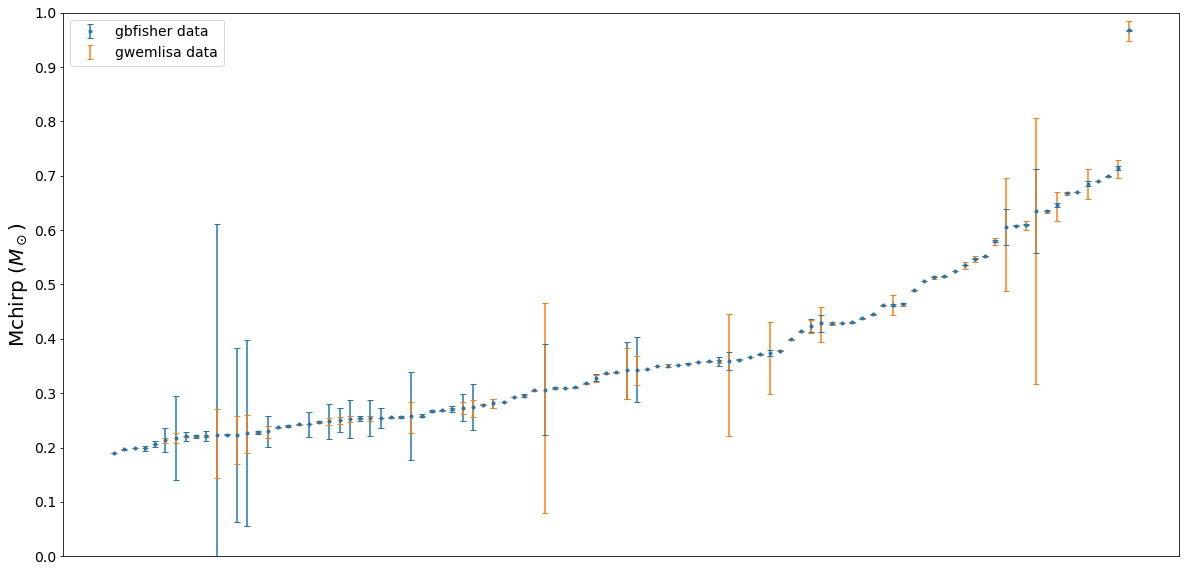

In [5]:
mchirp_columns = ['gf_mc', 'gf_s_mc', 'gl_mc','gl_+s_mc','gl_-s_mc']
data = []
for j in range(mc_gwemlisa.shape[0]):
    data.append([gbfisher['mchirp'][j], gbfisher['sigma_mchirp'][j], mc_gwemlisa['mc'][j], mc_gwemlisa['+s_mc'][j], mc_gwemlisa['-s_mc'][j]])
mchirp = pd.DataFrame(data,columns=mchirp_columns)
mchirp = mchirp.sort_values(['gf_mc']).reset_index()

# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.errorbar(x=range(lb,ub),y=mchirp['gf_mc'][cut],capsize=3,yerr=mchirp['gf_s_mc'][cut],linestyle='',marker='.')
plt.errorbar(x=range(lb,ub),y=mchirp['gl_mc'][cut],capsize=3,yerr=np.transpose(np.array(mchirp[['gl_-s_mc','gl_+s_mc']][cut])),linestyle='',marker='')
plt.ylabel('Mchirp ($M_\odot$)',fontsize=20)
ax.legend(['gbfisher data','gwemlisa data'],fontsize=14)
# fig.savefig('Mchirp_plot.jpg')

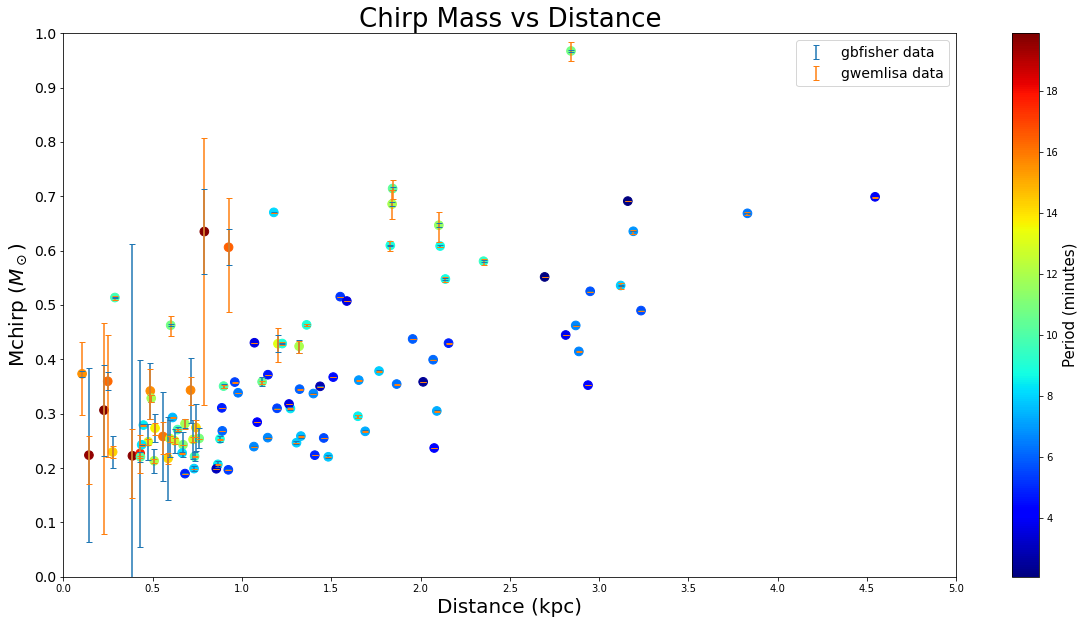

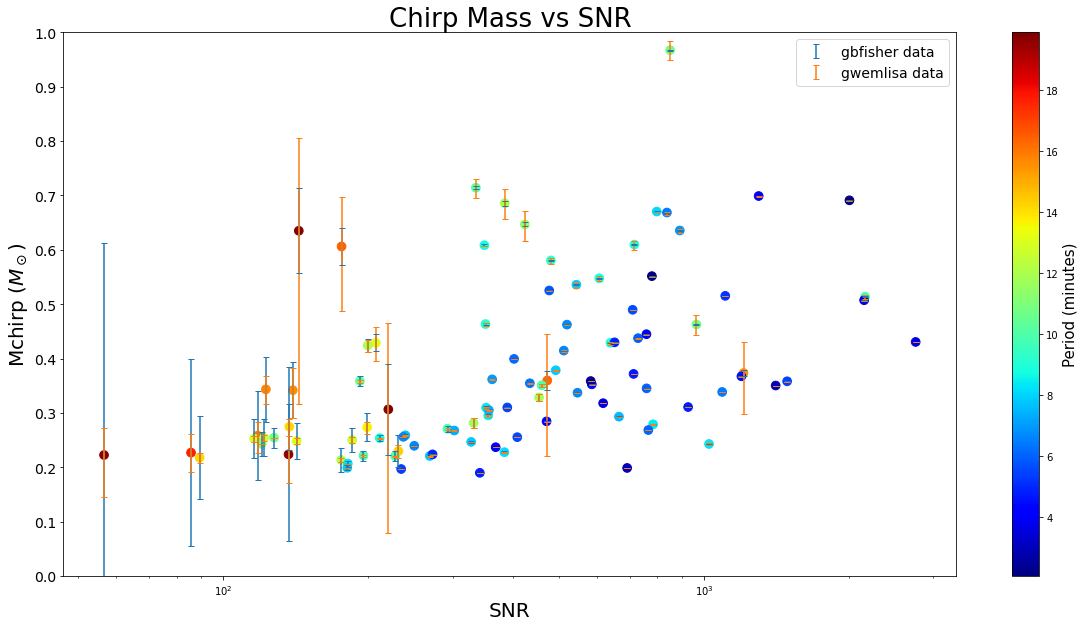

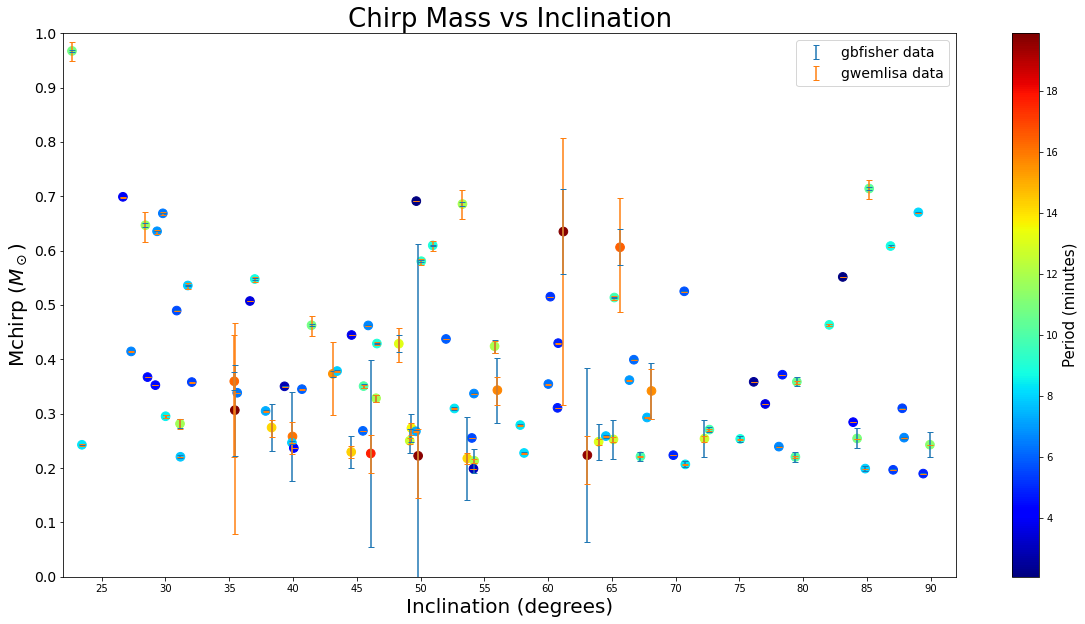

In [12]:
mchirp_columns = ['gf_mc', 'gf_s_mc', 'gl_mc','gl_+s_mc','gl_-s_mc']
data = []
for j in range(mc_gwemlisa.shape[0]):
    data.append([gbfisher['mchirp'][j], gbfisher['sigma_mchirp'][j], mc_gwemlisa['mc'][j], mc_gwemlisa['+s_mc'][j], mc_gwemlisa['-s_mc'][j]])
mchirp = pd.DataFrame(data,columns=mchirp_columns)
#mchirp = mchirp.sort_values(['gf_mc']).reset_index()

# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xlim(0,5)
plt.ylim(0,1)
plt.xticks(np.arange(0, 5.5, 0.5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.errorbar(x=gbfisher['distance'][cut]/1000.,y=mchirp['gf_mc'][cut],capsize=3,yerr=mchirp['gf_s_mc'][cut],linestyle='',marker='',label='gbfisher data')
plt.errorbar(x=gbfisher['distance'][cut]/1000.,y=mchirp['gl_mc'][cut],capsize=3,yerr=np.transpose(np.array(mchirp[['gl_-s_mc','gl_+s_mc']][cut])),linestyle='',marker='',label='gwemlisa data')
plt.scatter(x=gbfisher['distance'][cut]/1000.,y=mchirp['gf_mc'][cut],s=300,c=1/(30*gbfisher[cut]['f']),cmap='jet',marker='.')
plt.xlabel('Distance (kpc)',fontsize=20)
plt.ylabel('Mchirp ($M_\odot$)',fontsize=20)
plt.title('Chirp Mass vs Distance', fontsize=26)
ax.legend(fontsize=14)
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label='Period (minutes)',size=15)


fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xscale('log')
plt.errorbar(x=gbfisher['SNR'][cut],y=mchirp['gf_mc'][cut],capsize=3,yerr=mchirp['gf_s_mc'][cut],linestyle='',marker='',label='gbfisher data')
plt.errorbar(x=gbfisher['SNR'][cut],y=mchirp['gl_mc'][cut],capsize=3,yerr=np.transpose(np.array(mchirp[['gl_-s_mc','gl_+s_mc']][cut])),linestyle='',marker='',label='gwemlisa data')
plt.scatter(x=gbfisher['SNR'][cut],y=mchirp['gf_mc'][cut],s=300,c=1/(30*gbfisher[cut]['f']),cmap='jet',marker='.')
plt.xlabel('SNR',fontsize=20)
plt.ylabel('Mchirp ($M_\odot$)',fontsize=20)
plt.title('Chirp Mass vs SNR', fontsize=26)
ax.legend(fontsize=14)
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label='Period (minutes)',size=15)


fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xlim(22,92)
plt.ylim(0,1)
plt.xticks(np.arange(25, 95, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.errorbar(x=gbfisher['inclination'][cut],y=mchirp['gf_mc'][cut],capsize=3,yerr=mchirp['gf_s_mc'][cut],linestyle='',marker='',label='gbfisher data')
plt.errorbar(x=gbfisher['inclination'][cut],y=mchirp['gl_mc'][cut],capsize=3,yerr=np.transpose(np.array(mchirp[['gl_-s_mc','gl_+s_mc']][cut])),linestyle='',marker='',label='gwemlisa data')
plt.scatter(x=gbfisher['inclination'][cut],y=mchirp['gf_mc'][cut],s=300,c=1/(30*gbfisher[cut]['f']),cmap='jet',marker='.')
plt.xlabel('Inclination (degrees)',fontsize=20)
plt.ylabel('Mchirp ($M_\odot$)',fontsize=20)
plt.title('Chirp Mass vs Inclination', fontsize=26)
ax.legend(fontsize=14)
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label='Period (minutes)',size=15)

In [ ]:
i_gwemlisa_columns = ['i','+s_i','-s_i']
data = []
i = []
i_p = []
i_m = []
for j in range(gwemlisa.shape[0]):
    i.append(gwemlisa['i'][j])
    i_p.append(gwemlisa['+s_i'][j])
    i_m.append(gwemlisa['-s_i'][j])
    if(gwemlisa['O_n'][j] == gwemlisa['O_n'].max()):
        i_50, i_10, i_90 = np.percentile(i,50), np.percentile(i_m,50), np.percentile(i_p,50)
        data.append([i_50, i_90, i_10])
        i = []
        i_p = []
        i_m = []
i_gwemlisa = pd.DataFrame(data,columns=i_gwemlisa_columns)

incl_columns = ['gf_i', 'gf_s_i', 'gl_i','gl_+s_i','gl_-s_i']
data = []
for j in range(i_gwemlisa.shape[0]):
    data.append([gbfisher['inclination'][j], gbfisher['sigma_inclination'][j], i_gwemlisa['i'][j], i_gwemlisa['+s_i'][j], i_gwemlisa['-s_i'][j]])
incl = pd.DataFrame(data,columns=incl_columns)
incl = incl.sort_values(['gf_i']).reset_index()

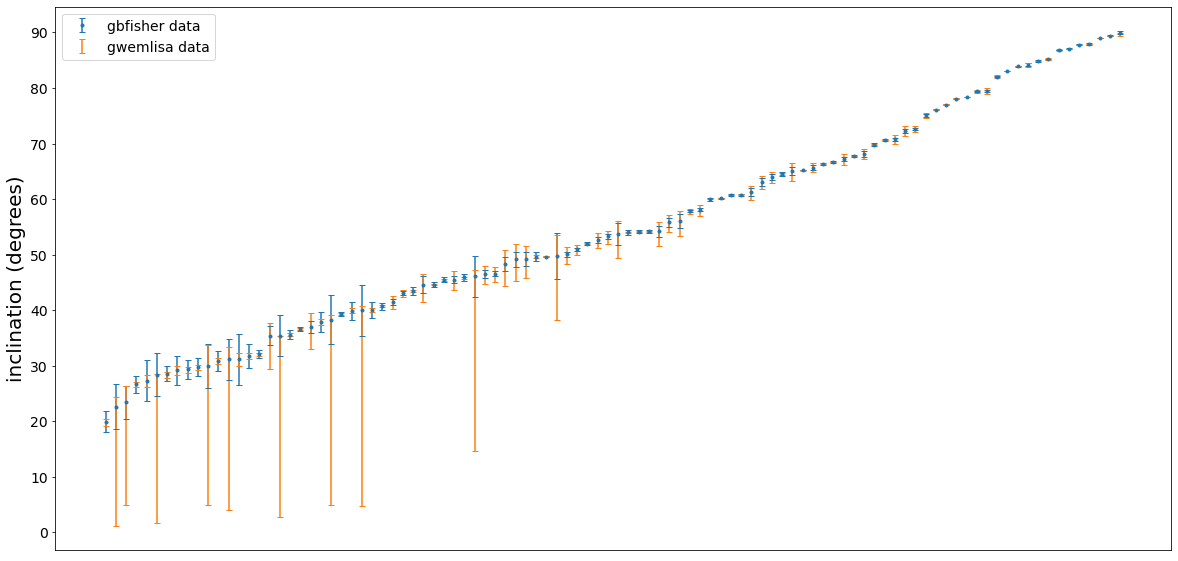

In [8]:
# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.yticks(np.arange(0, 100, 10))
plt.errorbar(x=range(lb,ub),y=incl['gf_i'][cut],capsize=3,yerr=incl['gf_s_i'][cut],linestyle='',marker='.')
plt.errorbar(x=range(lb,ub),y=incl['gl_i'][cut],capsize=3,yerr=np.transpose(np.array(incl[['gl_-s_i','gl_+s_i']][cut])),linestyle='',marker='')
plt.ylabel('inclination (degrees)',fontsize=20)
ax.legend(['gbfisher data','gwemlisa data'],fontsize=14)

In [9]:
q_gwemlisa_columns = ['q','+s_q','-s_q']
data = []
q = []
q_p = []
q_m = []
for j in range(gwemlisa.shape[0]):
    q.append(gwemlisa['q'][j])
    q_p.append(gwemlisa['+s_q'][j])
    q_m.append(gwemlisa['-s_q'][j])
    if(gwemlisa['O_n'][j] == gwemlisa['O_n'].max()):
        q_50, q_10, q_90 = np.percentile(q,50), np.percentile(q_m,50), np.percentile(q_p,50)
        data.append([q_50, q_90, q_10])
        q = []
        q_p = []
        q_m = []
q_gwemlisa = pd.DataFrame(data,columns=q_gwemlisa_columns)
q_gwemlisa = q_gwemlisa.sort_values(['q']).reset_index()

Text(0, 0.5, 'mass ratio')

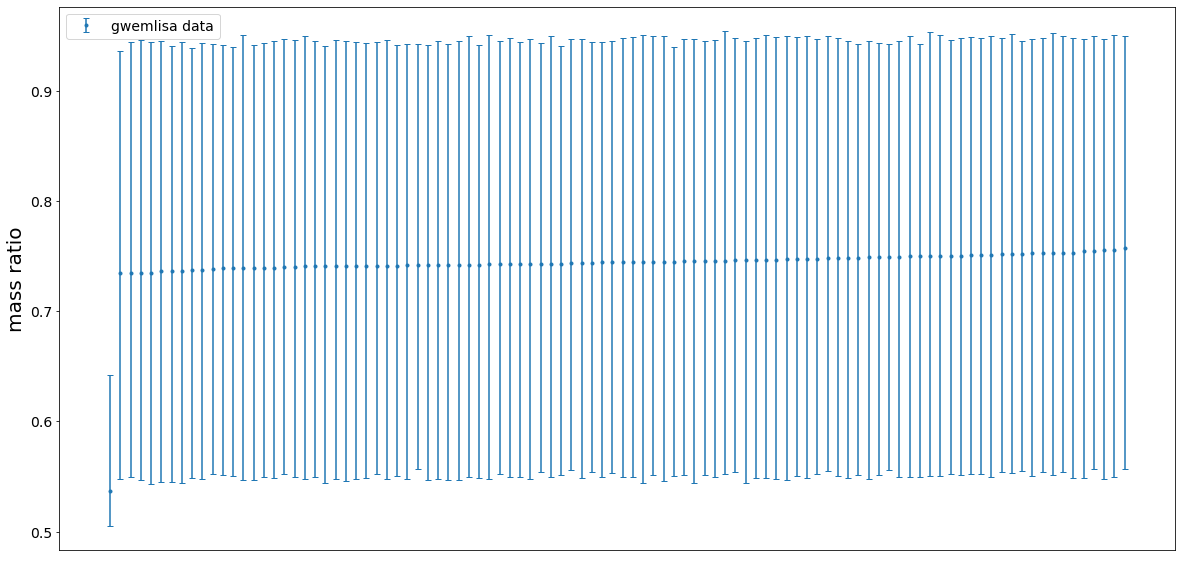

In [10]:
# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.errorbar(x=range(lb,ub),y=q_gwemlisa['q'][cut],capsize=3,yerr=np.transpose(np.array(q_gwemlisa[['-s_q','+s_q']][cut])),linestyle='',marker='.')
ax.legend(['gwemlisa data'],fontsize=14)
plt.ylabel('mass ratio',fontsize=20)
# fig.savefig('mass_ratio_plot.jpg')